In [91]:
import tensorflow as tf
import csv
import numpy as np

In [92]:
import tensorflow as tf
import csv

def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    # Create a list to store the data rows
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Step', 'Tag', 'Value'])
        # Write the data rows
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [93]:
import tensorflow as tf
import csv
from collections import defaultdict

# def tensorboard_to_separate_csv(event_file, output_dir):
#     """
#     Convert TensorBoard event file data to separate CSV files based on tags.

#     Args:
#         event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
#         output_dir (str): Directory where the CSV files should be saved. One CSV per tag.
#     """
#     # Create a dictionary to store data by tag
#     tag_data = defaultdict(list)
    
#     # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
#     for e in tf.compat.v1.train.summary_iterator(event_file):
#         for v in e.summary.value:
#             # Only consider scalar summaries
#             if v.HasField('simple_value'):
#                 tag = v.tag
#                 value = v.simple_value
#                 step = e.step
#                 tag_data[tag].append([step, value])

#     # Save each tag's data in a separate CSV file
#     for tag, data_rows in tag_data.items():
#         # Create a valid filename based on the tag
#         filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"  # Replace slashes with underscores for filename safety
        
#         with open(filename, 'w', newline='') as file:
#             writer = csv.writer(file)
#             # Write the header
#             writer.writerow(['Step', 'Value'])
#             # Write the data rows
#             writer.writerows(data_rows)
        
#         print(f"Data for tag '{tag}' has been written to {filename}")


In [95]:
def tensorboard_to_separate_csv(event_file, output_dir):
    from tensorflow.python.framework.errors_impl import DataLossError
    from collections import defaultdict
    import os, csv
    
    tag_data = defaultdict(list)
    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    tag = v.tag
                    value = v.simple_value
                    step = e.step
                    tag_data[tag].append([step, value])
    except DataLossError:
        print(f"Skipped corrupted file: {event_file}")
        return  # Exit this function for corrupted file

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")



In [96]:
import os

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Loop through all subdirectories of a parent directory, process TensorBoard files,
    and save results to a corresponding directory structure.

    Args:
        parent_dir (str): Parent directory containing TensorBoard event files.
        output_parent_dir (str): Parent directory where CSV files should be saved.
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:  # Check if the file is a TensorBoard event file
                # Full path to the event file
                event_file = os.path.join(root, file)

                # Recreate the directory structure in the output directory
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)

                # Create the output directory if it doesn't exist
                os.makedirs(output_dir, exist_ok=True)

                # Process the TensorBoard event file
                tensorboard_to_separate_csv(event_file, output_dir)

                print(f"Processed {event_file} -> {output_dir}")

In [123]:
tensorboard_to_separate_csv('../runs/fixed_punishment_rate_0.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895279/events.out.tfevents.1732895279.SocialAIs-Mac-Studio-3.local.38967.0', 'res/test')

Data for tag 'Agent_1/Loss' has been written to res/test/Agent_1_Loss_data.csv
Data for tag 'Agent_1/Reward' has been written to res/test/Agent_1_Reward_data.csv
Data for tag 'Agent_1/Epsilon' has been written to res/test/Agent_1_Epsilon_data.csv
Data for tag 'Agent_1/vote_for_punishment' has been written to res/test/Agent_1_vote_for_punishment_data.csv
Data for tag 'Agent_1/vote_against_punishment' has been written to res/test/Agent_1_vote_against_punishment_data.csv
Data for tag 'Agent_2/Loss' has been written to res/test/Agent_2_Loss_data.csv
Data for tag 'Agent_2/Reward' has been written to res/test/Agent_2_Reward_data.csv
Data for tag 'Agent_2/Epsilon' has been written to res/test/Agent_2_Epsilon_data.csv
Data for tag 'Agent_2/vote_for_punishment' has been written to res/test/Agent_2_vote_for_punishment_data.csv
Data for tag 'Agent_2/vote_against_punishment' has been written to res/test/Agent_2_vote_against_punishment_data.csv
Data for tag 'Agent_0/Loss' has been written to res/te

In [97]:
def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data.
        alpha (float): The smoothing factor (0 < alpha <= 1).

    Returns:
        numpy.ndarray: The EMA values.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]  # Initialize EMA with the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

import numpy as np

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.ndarray: The rolling average values.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    # Use np.convolve for efficient computation
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')



In [98]:
parent_dir = '../runs'
output_dir = 'res'
process_tensorboard_results(parent_dir, output_dir)

Skipped corrupted file: ../runs/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.01_onehot_5channel_20241130-14111732996371/events.out.tfevents.1732996371.SocialAIs-Mac-Studio-3.local.52665.0
Processed ../runs/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.01_onehot_5channel_20241130-14111732996371/events.out.tfevents.1732996371.SocialAIs-Mac-Studio-3.local.52665.0 -> res/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.01_onehot_5channel_20241130-14111732996371
Data for tag 'Agent_0/Encounters' has been written to res/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.01_onehot_5channel_20241130-14111732996371/Agent_0_Encounters_Wall/Agent_0_Encounters_data.csv
Processed ../runs/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_epsilon0.01_onehot_5channel_20241130-14111732996371/Agent_0_Encounters_Wall/events.out.tfevents.1732996372.SocialAIs-Mac-Studio-3.local.52665.3 -> res/fixed_punishment_rate_1.0_oneAs_size16_gem_has_value_ep

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

reward

In [124]:
folders = [
    # 'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891',
    # 'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585852',
    'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891', 
    'fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638845',
    'fixed_punishment_rate_0.25_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638747',
    'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638804',

]

folders = [
    'fixed_punishment_rate_1.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895307',
    'fixed_punishment_rate_0.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895279'
]

collective_rs = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'Reward' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_rs[ixs].append(data['Value'].to_numpy()[:12000])
collective_rs_ = [np.mean(collective_rs[i], axis=0) for i in range(len(collective_rs))]

Text(0.5, 1.0, 'Mean R')

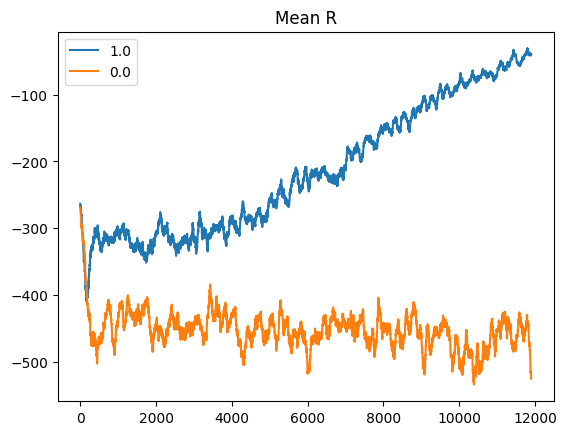

In [125]:
labels = ['1.0', '0.75,', '0.25', '0.0']
labels = ['1.0', '0.0']
alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_rs_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Mean R')

Text(0.5, 0.98, 'Reward')

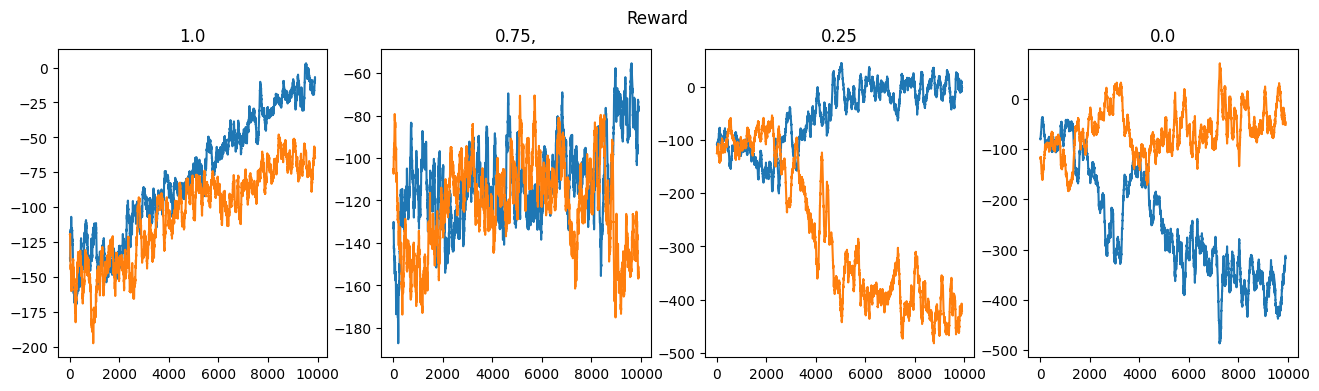

In [89]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))
for i in range(4):
    for j in range(len(collective_rs[i])):
        axes[i].plot(rolling_average(collective_rs[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Reward')

encounter_coins

In [112]:
# folders = [
#     # 'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891',
#     # 'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585852',
#     'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891', 
#     'fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638845',
#     'fixed_punishment_rate_0.25_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638747',
#     'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638804',

# ]

folders = [
    'fixed_punishment_rate_1.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895307',
    'fixed_punishment_rate_0.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895279'
]
entity_name = 'Coin'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:12000]) # trim if needed

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

In [104]:
collective[0][2].shape

(12000,)

Text(0.5, 1.0, 'Coin')

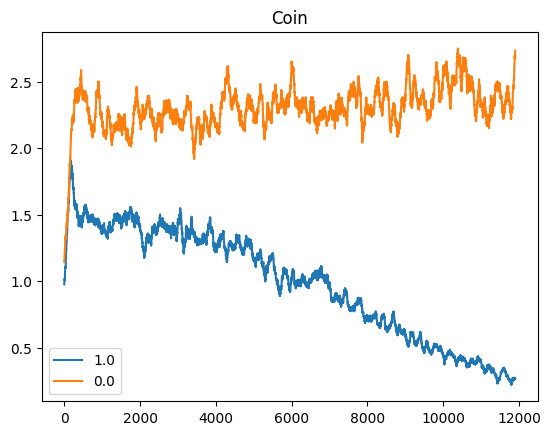

In [113]:
labels = ['1.0', '0.75,', '0.25', '0.0']
labels = ['1.0', '0.0']
alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Coin')

Text(0.5, 0.98, 'Coin')

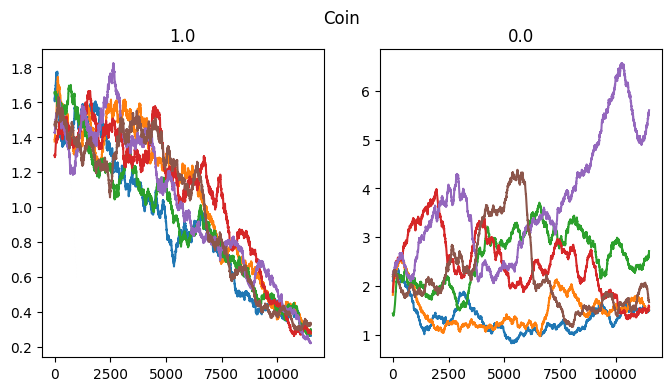

In [116]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500
for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Coin')


In [118]:
folders = [
    # 'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891',
    # 'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585852',
    'fixed_punishment_rate_1.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_20241125-20111732585891', 
    'fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638845',
    'fixed_punishment_rate_0.25_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638747',
    'fixed_punishment_rate_0.0_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_20241126-11111732638804',

]

folders = [
    'fixed_punishment_rate_1.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895307',
    'fixed_punishment_rate_0.0_sixAs_size16_gem_has_value_epsilon0.01_20241129-10111732895279'
]

entity_name = 'Gem'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:12000])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

Text(0.5, 1.0, 'Gem')

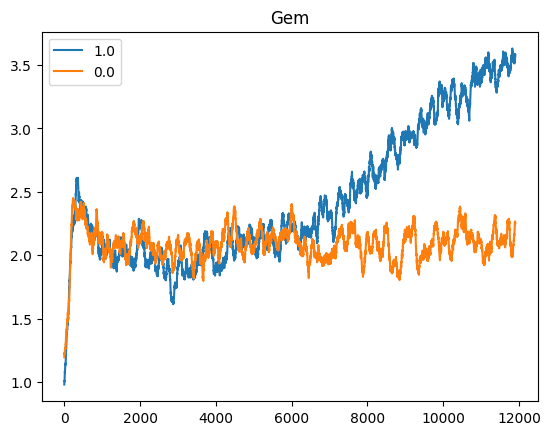

In [119]:
labels = ['1.0', '0.75,', '0.25', '0.0']
labels = ['1.0', '0.0']
alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Gem')

Text(0.5, 0.98, 'Gem')

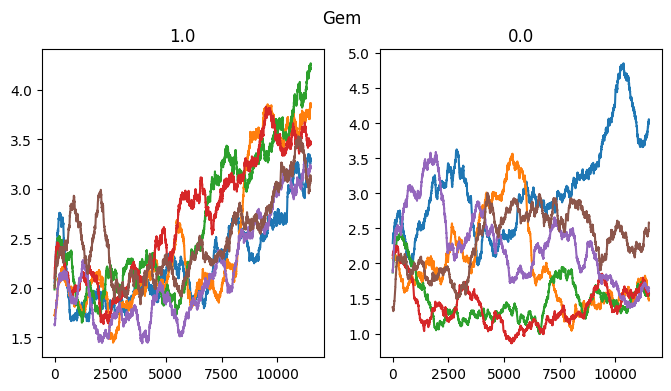

In [121]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500

for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Gem')